# Tensorflow to Qkeras to Hls4ml


In [1]:
import numpy as np

seed = 0
np.random.seed(seed)

import tensorflow as tf

tf.random.set_seed(seed)


import sys

sys.path.append("/home/webphy/Desktop/dnn_processor/")  # just to enable `dataset`
sys.path.append(
    "/home/webphy/Desktop/dnn_processor/dataset/"
)  # just to enable `dataset`

import dataset
import plotting
import qkeras
import keras

2024-02-07 19:58:30.700858: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 19:58:30.723412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 19:58:30.723434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 19:58:30.724095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 19:58:30.728073: I tensorflow/core/platform/cpu_feature_guar

# fetch dataset


In [2]:
BATCH_SIZE = 64
train_images_rgx = "../dataset/train_set_4x/*/*.jpeg"
valid_images_rgx = "../dataset/test_set_4x/*/*.jpeg"

train_ds, val_ds, nclasses = dataset.create_datasets(
    train_images_rgx, valid_images_rgx, BATCH_SIZE, 128
)

2024-02-07 19:58:32.020281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 19:58:32.043016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 19:58:32.043161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# load the model


In [3]:
exp_id = "manual_test_4x"


model = keras.models.load_model(
    f"../neural_network/handmade/saved_models/manual_test_4x/model.h5",
    compile=False,
)
model.compile(
    "adam", loss=tf.keras.losses.CategoricalCrossentropy(True), metrics=["accuracy"]
)

score = model.evaluate(val_ds)
print("Accuracy: {}".format(score[1]))

2024-02-07 19:58:34.638311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


5/5 [==============================] - 2s 22ms/step - loss: 0.3979 - accuracy: 0.8697
Accuracy: 0.8697317838668823


# quantize model


In [4]:
import qkeras
from qkeras import *
from keras.layers import (
    Conv2D,
    DepthwiseConv2D,
    Activation,
    Dense,
    Flatten,
    MaxPooling2D,
    GlobalAveragePooling2D,
)


BIT_WIDTH = 8
DEFAULT_ALPHA = 1


def create_qkeras_model_from_keras_model(keras_model):
    x = x_in = keras.Input(shape=keras_model.layers[0].output.shape[1:])

    x = QActivation(quantized_relu(BIT_WIDTH, 0))(x)

    for l in keras_model.layers:
        if isinstance(l, Conv2D):
            qconv2d = QConv2D(
                l.filters,
                l.kernel_size,
                l.strides,
                l.padding,
                kernel_quantizer=quantized_bits(BIT_WIDTH, 0, 1, alpha=DEFAULT_ALPHA),
                bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1, alpha=DEFAULT_ALPHA),
            )
            x = qconv2d(x)
            qconv2d.set_weights(l.get_weights())

        elif isinstance(l, DepthwiseConv2D):
            qDepthwiseConv2D = QDepthwiseConv2D(
                l.kernel_size,
                l.strides,
                l.padding,
                depthwise_quantizer=quantized_bits(
                    BIT_WIDTH, 0, 1, alpha=DEFAULT_ALPHA
                ),
                bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1, alpha=DEFAULT_ALPHA),
            )
            x = qDepthwiseConv2D(x)
            qDepthwiseConv2D.set_weights(l.get_weights())

        elif isinstance(l, Activation):
            activation_name = l.get_config()["activation"]
            print(activation_name)
            if activation_name == "tanh":
                x = QActivation(quantized_tanh(BIT_WIDTH, True))(x)
            elif activation_name == "relu":
                x = QActivation(quantized_relu(BIT_WIDTH, 0))(x)
            elif activation_name == "linear":
                x = QActivation(quantized_bits(BIT_WIDTH, 0, 1))(x)
            else:
                print(f"{l.name} was not quantized")

        elif isinstance(l, Flatten):
            # necessary because the layer before Flatten doesnt have avtivation
            x = QActivation(quantized_bits(BIT_WIDTH - 4, 0, 1))(x)
            x = Flatten()(x)

        elif isinstance(l, Dense):
            qdense = QDense(
                l.units,
                kernel_quantizer=quantized_bits(BIT_WIDTH, 0, 1, alpha=DEFAULT_ALPHA),
                bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1, alpha=DEFAULT_ALPHA),
            )
            # just for testing the latency
            x = qdense(x)
            qdense.set_weights(l.get_weights())

        elif isinstance(l, MaxPooling2D):
            x = MaxPooling2D()(x)

        elif isinstance(l, GlobalAveragePooling2D):
            globalAveragePooling2D = GlobalAveragePooling2D()
            x = globalAveragePooling2D(x)
            x = QActivation(quantized_bits(BIT_WIDTH, 0, 1, alpha=DEFAULT_ALPHA))(x)
        else:
            print(f"{l.name} layer was not quantized...")

    qkeras_model = keras.models.Model(x_in, x)

    return qkeras_model


qkeras_model = create_qkeras_model_from_keras_model(model)
qkeras_model.compile(
    keras.optimizers.Adam(0.0005),
    loss=keras.losses.CategoricalCrossentropy(True),
    metrics=["accuracy"],
)
qkeras_model.summary()

input_2 layer was not quantized...
relu
relu
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 q_activation (QActivation)  (None, 128, 128, 3)       0         
                                                                 
 q_conv2d (QConv2D)          (None, 32, 32, 4)         196       
                                                                 
 q_activation_1 (QActivatio  (None, 32, 32, 4)         0         
 n)                                                              
                                                                 
 q_conv2d_1 (QConv2D)        (None, 15, 15, 16)        592       
                                                                 
 q_activation_2 (QActivatio  (None, 15, 15, 16)        0         
 n)             

# evaluate quantized model

In [5]:
from qkeras.estimate import print_qstats

qkeras_model.evaluate(val_ds)
print_qstats(qkeras_model)
# free memory
del model

5/5 [==============================] - 1s 32ms/step - loss: 0.5094 - accuracy: 0.7778
Instructions for updating:
Use ref() instead.


/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(
Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_conv2d                      : 196608 (smult_8_8)
    q_conv2d_1                    : 129600 (smult_8_8)
    q_conv2d_2                    : 18000 (smult_8_8)
    q_dense                       : 5625  (smult_8_4)

Number of operation types in model:
    smult_8_4                     : 5625
    smult_8_8                     : 344208

Weight profiling:
    q_conv2d_weights               : 192   (8-bit unit)
    q_conv2d_bias                  : 4     (8-bit unit)
    q_conv2d_1_weights             : 576   (8-bit unit)
    q_conv2d_1_bias                : 16    (8-bit unit)
    q_conv2d_2_weights             : 80    (8-bit unit)
    q_conv2d_2_bias                : 5     (8-bit unit)
    q_dense_weights                : 5625  (8-bit unit)
    q_dense_bias                   : 5     (8-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.0102
    q_conv2d_1                     : 0.0186
    q_conv2d_2                     

# fine tune quantized model


In [6]:
qkeras_model.fit(train_ds, batch_size=256, epochs=5, validation_data=val_ds)
trial_id = "handmade_model"
qkeras_model.save(f"saved_qmodels/{trial_id}.h5")

Epoch 1/5


2024-02-07 19:58:42.019066: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/q_activation_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-07 19:58:42.120555: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdbdc73b300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 19:58:42.120615: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-07 19:58:42.128856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707346722.186379    8714 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 [==============================] - 2s 6ms/step - loss: 2.4786 - accuracy: 0.8170 - val_loss: 0.4879 - val_accuracy: 0.8046
Epoch 2/5
55/55 [==============================] - 0s 6ms/step - loss: 0.2682 - accuracy: 0.8997 - val_loss: 0.3717 - val_accuracy: 0.8544
Epoch 3/5
55/55 [==============================] - 0s 6ms/step - loss: 0.2552 - accuracy: 0.9094 - val_loss: 0.4025 - val_accuracy: 0.8391
Epoch 4/5
55/55 [==============================] - 0s 6ms/step - loss: 0.2604 - accuracy: 0.9028 - val_loss: 0.4108 - val_accuracy: 0.8238
Epoch 5/5
55/55 [==============================] - 0s 6ms/step - loss: 0.2931 - accuracy: 0.8884 - val_loss: 0.4842 - val_accuracy: 0.8238


/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)

loaded_qkeras_model = keras.models.load_model(f"saved_qmodels/{trial_id}.h5", co)
loaded_qkeras_model.evaluate(val_ds)

# free memory
del loaded_qkeras_model

5/5 [==============================] - 0s 4ms/step - loss: 0.4842 - accuracy: 0.8238


# convert quantized model to HLS4ml


In [19]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(
    qkeras_model,
    granularity="name",
    default_precision="fixed<32,16>",
    default_reuse_factor=9000,
)

config["Model"]["Strategy"] = "Resource"

for layer in config["LayerName"].keys():
    config["LayerName"][layer]["Strategy"] = "Resource"

#config["LayerName"]["q_dense"]["Strategy"] = "Resource"
#config["LayerName"]["q_dense"]["Precision"] = "fixed<4,1>"


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 32, 32, 4]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32, 32, 4]], output shape: [None, 32, 32, 4]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 15, 15, 16]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 5]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 15, 15, 5]], output shape: [None, 15, 15, 5]
Layer name: flatten, layer type: Resh

/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [20]:

plotting.print_dict(config)

Model
  Precision:         fixed<32,16>
  ReuseFactor:       9000
  Strategy:          Resource
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_1
    Trace:           False
    Precision
      result:        fixed<32,16>
    Strategy:        Resource
  q_activation
    Trace:           False
    Precision
      result:        ufixed<8,0,RND_CONV,SAT>
    Strategy:        Resource
  q_conv2d
    Trace:           False
    Precision
      result:        fixed<32,16>
      weight:        fixed<8,1>
      bias:          fixed<8,1>
    Strategy:        Resource
  q_conv2d_linear
    Trace:           False
    Precision
      result:        fixed<32,16>
    Strategy:        Resource
  q_activation_1
    Trace:           False
    Precision
      result:        ufixed<8,0,RND_CONV,SAT>
    Strategy:        Resource
  q_conv2d_1
    Trace:           False
    Precision
      result:        fixed<32,16>
      weight:        fixed<8,1>
      bias:          fixed<8,1>

# build for pynq without DMA

In [21]:

hls_model = hls4ml.converters.convert_from_keras_model(
    qkeras_model,
    hls_config=config,
    output_dir=f"qkeras_model/hls4ml_prj",
    part="xc7z020-clg400-1",
    io_type="io_stream",
)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 32, 32, 4]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32, 32, 4]], output shape: [None, 32, 32, 4]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 15, 15, 16]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 5]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 15, 15, 5]], output shape: [None, 15, 15, 5]
Layer name: flatten, layer type: Resh

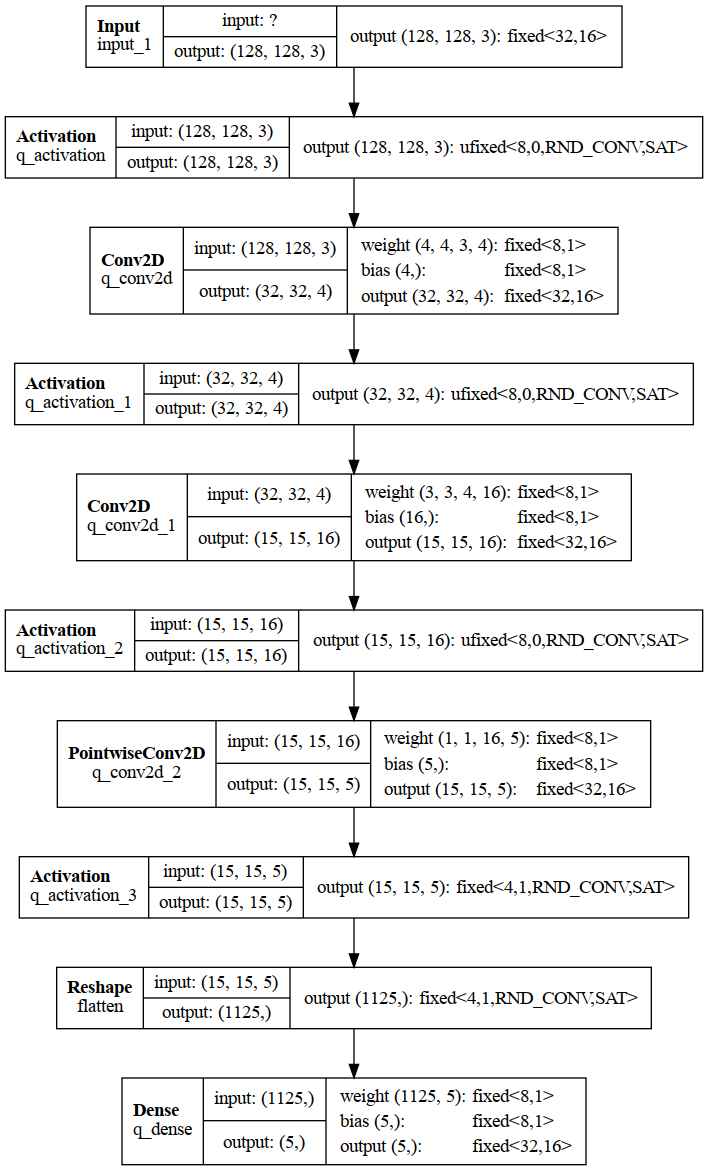

In [22]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [23]:
hls_model.compile()

Writing HLS project
Done


/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [24]:
classes = ["acf_alv", "acf_chap", "reboco", "tijolo_alv", "tijolo_chap"]
X_test = np.load("../dataset/x_test_set_4x.npy")
y_test = np.load("../dataset/y_test_set_4x.npy")

y_qkeras = qkeras_model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

np.save('qkeras_model/y_qkeras.npy', y_qkeras)
np.save('qkeras_model/y_hls.npy', y_hls)

9/9 [==============================] - 0s 2ms/step


9/9 [==============================] - 0s 2ms/step
Accuracy baseline:  0.8697318007662835
Accuracy pruned, quantized: 0.8237547892720306
Accuracy hls4ml: 0.8275862068965517


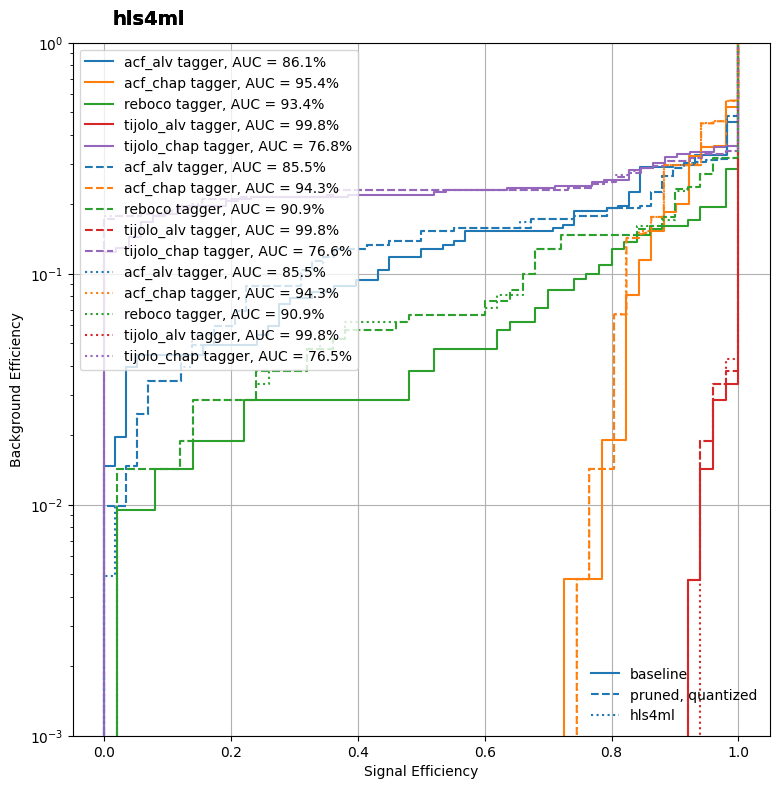

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model_ref = keras.models.load_model(
    "/home/webphy/Desktop/dnn_processor/neural_network/handmade/saved_models/manual_test_4x/model.h5"
)
y_ref = model_ref.predict(X_test)

print(
    "Accuracy baseline:  {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))
    )
)
print(
    "Accuracy pruned, quantized: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))
    )
)
print(
    "Accuracy hls4ml: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle="--")
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=":")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--"), Line2D([0], [0], ls=":")]
from matplotlib.legend import Legend

leg = Legend(
    ax,
    lines,
    labels=["baseline", "pruned, quantized", "hls4ml"],
    loc="lower right",
    frameon=False,
)
ax.add_artist(leg)

### build

In [ ]:
hls_model.build(csim=False)

In [ ]:
hls4ml.report.read_vivado_report(f"one_layer_model/hls4ml_prj")

# build for Pynq

In [26]:
output_dir=f"deploy/qkeras_model/hls4ml_prj"

hls_model = hls4ml.converters.convert_from_keras_model(
    qkeras_model,
    hls_config=config,
    output_dir=output_dir,
    part="xc7z020-clg400-1",
    io_type="io_stream",
    backend='VivadoAccelerator',
    board='pynq-z2'
)

hls_model.compile()
hls_model.build(csim=False, export=True, bitfile=True)

/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(
/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 32, 32, 4]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32, 32, 4]], output shape: [None, 32, 32, 4]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 15, 15, 16]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 5]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 15, 15, 5]], output shape: [None, 15, 15, 5]
Layer name: flatten, layer type: Resh

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '6.464',
  'BestLatency': '3293174',
  'WorstLatency': '3293581',
  'IntervalMin': '475138',
  'IntervalMax': '3293186',
  'BRAM_18K': '204',
  'DSP': '0',
  'FF': '33497',
  'LUT': '52781',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.19,
  'TNS': 0.0,
  'WHS': 0.012,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

In [27]:
hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in deploy/qkeras_model/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Wed Feb  7 20:14:23 2024

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 6.464 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+--------+---------+----------+
    |  Latency (cycles) |   Latency (absolute)  |     Interval     | Pipeline |
    |   min   |   max   |    min    |    max    |   min  |   max   |   Type   |
   

# FIFO depth optimization

In [ ]:
import hls4ml


config["Flows"] = ["vivado:fifo_depth_optimization"]
hls4ml.model.optimizer.get_optimizer("vivado:fifo_depth_optimization").configure(
    profiling_fifo_depth=100_000
)


hls_model = hls4ml.converters.convert_from_keras_model(
    qkeras_model,
    hls_config=config,
    io_type="io_stream",
    output_dir=f"deploy/qmodel_{trial_id}_fifo_opt/hls4ml_prj",
    part="xc7z020clg400-1",
    backend="Vivado",
)

hls_model.build(reset=False, csim=True, synth=True, cosim=True)

In [ ]:
hls4ml.report.read_vivado_report(f"deploy/qmodel_{trial_id}_fifo_opt/hls4ml_prj")

# FIFO depth optimization for PYNQ

In [ ]:
hls_model = hls4ml.converters.convert_from_keras_model(
    qkeras_model,
    hls_config=config,
    output_dir=f"deploy/qmodel_{trial_id}_fifo_opt_pynq/hls4ml_prj",
    part="xc7z020clg400-1",
    io_type="io_stream",
    backend='VivadoAccelerator',
    board='pynq-z2'
)

In [ ]:
hls_model.compile()

In [ ]:
hls_model.build(
    reset=False, csim=True, synth=True, cosim=True, export=True, bitfile=True
)

In [ ]:
hls4ml.report.read_vivado_report(f"deploy/qmodel_{trial_id}_fifo_opt_pynq/hls4ml_prj")